This tutorial can be downloaded [link](http://greatfire.uchicago.edu/west-public/West/raw/master/doc/tutorials/west_100.ipynb).

# 1.0 Getting Started: GW calculation

In order to compute the GW electronic structure of the silane molecule you need to run `pw.x`, `wstat.x` and `wfreq.x` in sequence. 

## Step 1: Ground State 

The ground state electronic structure of silane molecule with [QuantumEspresso 6.1.0](https://www.quantum-espresso.org/) is obtained by running `pw.x`. The pseudopotential files for **Si** and **H** in UPF format can be downloaded from: [QE-PP](https://www.quantum-espresso.org/pseudopotentials) database, or from [SG15](http://www.quantum-simulation.org/potentials/sg15_oncv/upf/) database. Check out the `pw.x` [input description](https://www.quantum-espresso.org/Doc/INPUT_PW.html) in order to generate an input file for QuantumEspresso called `pw.in`. 

Download these files in your current working directory:

In [1]:
%%bash
wget -N -q http://www.west-code.org/doc/training/silane/pw.in
wget -N -q http://www.quantum-simulation.org/potentials/sg15_oncv/upf/H_ONCV_PBE-1.2.upf
wget -N -q http://www.quantum-simulation.org/potentials/sg15_oncv/upf/Si_ONCV_PBE-1.2.upf

Let's inspect the ``pw.in`` file, input for ``pw.x``.

In [2]:
%%bash
cat pw.in

&control
calculation  = 'scf'
restart_mode = 'from_scratch'
pseudo_dir   = './'
outdir       = './'
prefix       = 'silane'
wf_collect   = .TRUE.
/
&system
ibrav           = 1
celldm(1)       = 20
nat             = 5
ntyp            = 2
ecutwfc         = 25.0
nbnd            = 10
assume_isolated ='mp'
/
&electrons
diago_full_acc = .TRUE.
/
ATOMIC_SPECIES
Si 28.0855  Si_ONCV_PBE-1.2.upf
H  1.00794   H_ONCV_PBE-1.2.upf
ATOMIC_POSITIONS bohr
Si      10.000000   10.000000  10.000000
H       11.614581   11.614581  11.614581
H        8.385418    8.385418  11.614581
H        8.385418   11.614581   8.385418
H       11.614581    8.385418   8.385418
K_POINTS {gamma}


Run ``pw.in`` on 2 cores.

In [ ]:
%%bash 
mpirun -n 2 pw.x < pw.in > pw.out 

The output file ``pw.out`` contains information about the ground state calculation.

## Step 2: Screening

The static dielectric screening is computed using the projective dielectric eigendecomposition (PDEP) technique. Check out the ``wstat.x`` [input description](http://www.west-code.org/doc/West/latest/) and generate an input file for WEST called ``wstat.in``.

Download this file in your current working directory:

In [3]:
%%bash
wget -N -q http://www.west-code.org/doc/training/silane/wstat.in

Let's inspect the ``wstat.in`` file, input for ``wstat.x``.

In [4]:
%%bash
cat wstat.in

input_west:
    qe_prefix: silane
    west_prefix: silane
    outdir: ./

wstat_control:
    wstat_calculation: S
    n_pdep_eigen: 50

Run ``wstat.in`` on 2 cores.

In [ ]:
%%bash 
mpirun -n 2 wstat.x -i wstat.in > wstat.out 

The output file ``wstat.out`` contains information about the PDEP iterations, and the dielectric eigenvalues can be found in the file ``<west_prefix>.wstat.save/wstat.json``.

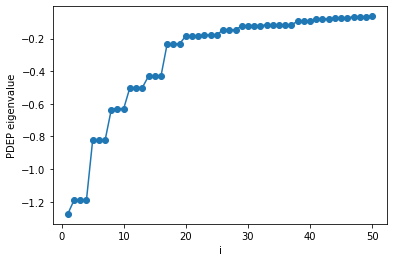

In [5]:
import json
import numpy as np
import matplotlib.pyplot as plt

with open('silane.wstat.save/wstat.json') as json_file:
    data = json.load(json_file)

ev = np.array(data["exec"]["davitr"][-1]["ev"],dtype="f8")
iv = np.linspace(1,ev.size,ev.size,endpoint=True)

plt.plot(iv,ev,'o-',label="XXX")
plt.xlabel("i")
plt.ylabel("PDEP eigenvalue")

plt.show()

## Step 3: GW

The GW electronic structure is computed treating the frequency integration of the correlation part of the self energy with the Contour Deformation techinique and by computing the dielectric screening at multipole frequencies with Lanczos iterations. Check out the ``wfreq.x`` [input description](http://www.west-code.org/doc/West/latest/) and generate an input file for WEST called ``wfreq.in``.

Download this file in your current working directory:

In [6]:
%%bash
wget -N -q http://www.west-code.org/doc/training/silane/wfreq.in

Let's inspect the ``wfreq.in`` file, input for ``wfreq.x``.

In [7]:
%%bash
cat wfreq.in

input_west:
    qe_prefix: silane
    west_prefix: silane
    outdir: ./

wstat_control:
    wstat_calculation: S
    n_pdep_eigen: 50

wfreq_control:
    wfreq_calculation: XWGQ
    n_pdep_eigen_to_use: 50
    qp_bandrange: [1,5]
    n_refreq: 300
    ecut_refreq: 2.0

Run ``wfreq.in`` on 2 cores.

In [ ]:
%%bash 
mpirun -n 2 wfreq.x -i wfreq.in > wfreq.out 

The output file ``wfreq.out`` contains information about the calculation of the GW self-energy, and the corrected electronic structure can be found in the file ``<west_prefix>.wstat.save/wfreq.json``.

In [53]:
import json
import numpy as np

with open('silane.wfreq.save/wfreq.json') as json_file:
    data = json.load(json_file)

k=1 
kindex = f"K{k:06d}"
    
print(kindex)
print()
    
bandmap = data["output"]["Q"]["bandmap"]
eqp = data["output"]["Q"][kindex]

for i, b in enumerate(bandmap) : 
    print(f"band = {b}")
    for key in eqp:
        if("re" in eqp[key]):
            print(f"   {key} = {eqp[key]['re'][i]:.3f}, {eqp[key]['im'][i]:.3f} eV")
        else:
            print(f"   {key} = {eqp[key][i]:.3f} eV")
    print()

K000001

band = 1
   sigmax = -17.606 eV
   vxcl = -11.250 eV
   vxcnl = 0.000 eV
   hf = -6.357 eV
   z = 0.661 eV
   eks = -13.236 eV
   eqpLin = -16.273 eV
   eqpSec = -16.135 eV
   sigmac_eks = 1.765, 0.015 eV
   sigmac_eqpLin = 3.577, 0.076 eV
   sigmac_eqpSec = 3.439, 0.116 eV
   sigma_diff = -0.023 eV

band = 2
   sigmax = -15.766 eV
   vxcl = -11.243 eV
   vxcnl = 0.000 eV
   hf = -4.523 eV
   z = 0.869 eV
   eks = -8.231 eV
   eqpLin = -12.151 eV
   eqpSec = -12.046 eV
   sigmac_eks = 0.011, 0.003 eV
   sigmac_eqpLin = 0.730, 0.009 eV
   sigmac_eqpSec = 0.707, 0.009 eV
   sigma_diff = -0.003 eV

band = 3
   sigmax = -15.765 eV
   vxcl = -11.243 eV
   vxcnl = 0.000 eV
   hf = -4.523 eV
   z = 0.869 eV
   eks = -8.231 eV
   eqpLin = -12.148 eV
   eqpSec = -12.044 eV
   sigmac_eks = 0.013, 0.003 eV
   sigmac_eqpLin = 0.732, 0.009 eV
   sigmac_eqpSec = 0.709, 0.009 eV
   sigma_diff = -0.003 eV

band = 4
   sigmax = -15.765 eV
   vxcl = -11.242 eV
   vxcnl = 0.000 eV
   hf = -4.523

Explanation of keys:

- `k` : k-point
- `s` : spin
- `b` : band
- `sigmax` : $\langle k,s,b|\Sigma_x|k,s,b\rangle$, Exchange self-energy
- `vxcl` : $\langle k,s,b|V_{xc}^{local}|k,s,b\rangle$, Local exchange and correlation
- `vxcnl` : $\langle k,s,b|V_{xc}^{non-local}|k,s,b\rangle$, Non-local exchange and correlation
- `hf` : $\varepsilon_{k,s,b}+\langle k,s,b|\Sigma_x-V_{xc}^{local}-V_{xc}^{non-local}|k,s,b\rangle$,  perturbative Hartree-Fock
- `z` : 
- `eks` : $\varepsilon_{k,s,b} = \langle k,s,b|H_{KS}|k,s,b\rangle$, Kohn-Sham eigenvalue
- `eqpLin` : $\varepsilon_{k,s,b} + \langle k,s,b|\Sigma_c(\varepsilon_{k,s,b})|k,s,b\rangle$, Kohn-Sham eigenvalue
- `eqpSec` : $\varepsilon_{k,s,b} + \langle k,s,b|\Sigma_c(\varepsilon_{k,s,b})|k,s,b\rangle$, Kohn-Sham eigenvalue
- `sigmac_eks` : $\langle k,s,b|\Sigma_c(\varepsilon_{k,s,b})|k,s,b\rangle$, Correlation self-energy evaluated at $\varepsilon_{k,s,b}$
- `sigmac_eqpLin` : $\langle k,s,b|\Sigma_c(\varepsilon_{k,s,b})|k,s,b\rangle$, Correlation self-energy evaluated at $\varepsilon_{k,s,b}$
- `sigmac_eqpSec` : $\langle k,s,b|\Sigma_c(\varepsilon_{k,s,b})|k,s,b\rangle$, Correlation self-energy evaluated at $\varepsilon_{k,s,b}$


In [13]:
from westpy import ElectronicStructure

 
 _    _ _____ _____ _____            
| |  | |  ___/  ___|_   _|           
| |  | | |__ \ `--.  | |_ __  _   _  
| |/\| |  __| `--. \ | | '_ \| | | | 
\  /\  / |___/\__/ / | | |_) | |_| | 
 \/  \/\____/\____/  \_/ .__/ \__, | 
                       | |     __/ | 
                       |_|    |___/  
 
WEST version     :  3.1.1
Today            :  2021-05-19 21:55:09.144532


In [23]:
es = ElectronicStructure()
es.addKey("eks","Kohn-Sham energy (eV)")
es.addKey("eqp","Quasiparticle energy (eV)")

In [24]:
for i, b in enumerate(bandmap) : 
    es.addDataPoint([1,1,b],"eks",eqp["eks"][i])
    es.addDataPoint([1,1,b],"eqp",eqp["eqpSec"][i])

Requested (emin,emax) :  -20 5
Detected  (emin,emax) :  -16.134751796731177 0.6648562238096314
output written in :  dos.png
waiting for user to close image preview...


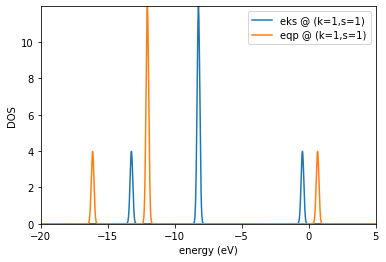

In [30]:
es.plotDOS(k=1,s=1,energyKeys=["eks","eqp"],energyRange=[-20,5,0.01])

In [80]:
%%bash
wget -N -q http://www.west-code.org/doc/training/silane/wfreq_spec.in

In [81]:
%%bash
cat wfreq_spec.in

input_west:
    qe_prefix: silane
    west_prefix: silane
    outdir: ./

wstat_control:
    wstat_calculation: S
    n_pdep_eigen: 50

wfreq_control:
    wfreq_calculation: XwgQP
    n_pdep_eigen_to_use: 50
    qp_bandrange: [1,5]
    n_refreq: 300
    ecut_refreq: 2.0
    ecut_spectralf: [-1.5,0.5]
    n_spectralf: 1000

In [ ]:
%%bash 
mpirun -n 2 wfreq.x -i wfreq_spec.in > wfreq_spec.out 

K000001
dict_keys(['freqlist', 'K000001'])
band = 4
-8.230102882308456 0.012646784475642808


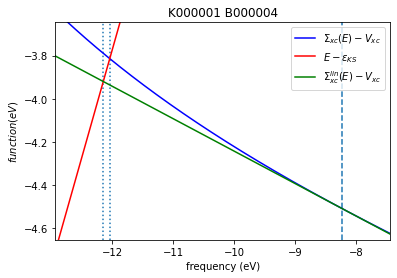


band = 5
-0.46551944347590346 -0.34895815035534355


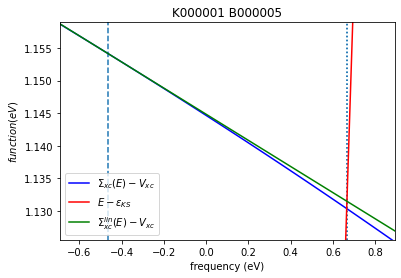

In [128]:
import json
import numpy as np
import matplotlib.pyplot as plt

with open('silane.wfreq.save/wfreq.json') as json_file:
    data = json.load(json_file)

k = 1 
kindex = f"K{k:06d}"
    
print(kindex)
print(data["output"]["P"].keys())

bandmap = data["output"]["Q"]["bandmap"]
eqp = data["output"]["Q"][index]

freqlist = np.array(data["output"]["P"]["freqlist"], dtype="f8")
spf = data["output"]["P"][index]

for i, b in enumerate(bandmap) : 
    print(f"band = {b}")
    eks, eqpLin, eqpSec = eqp['eks'][i], eqp['eqpLin'][i], eqp['eqpSec'][i]
    sigmax, vxcl, vxcnl = eqp['sigmax'][i], eqp['vxcl'][i], eqp['vxcnl'][i]
    sigmac_eks = eqp['sigmac_eks']['re'][i]
    sigmac_eqpLin = eqp['sigmac_eqpLin']['re'][i]
    sigmac_eqpSec = eqp['sigmac_eqpSec']['re'][i]
    z = eqp['z'][i]
    print(eks,eqp['sigmac_eks']['re'][i])
    
    bindex = f"B{b:06d}"
    sigmac = np.array(spf[bindex]['sigmac']['re'], dtype="f8")
    
    plt.plot(freqlist,sigmac+sigmax-vxcl-vxcnl,'b-',label=r"$\Sigma_{xc}(E)-V_{xc}$")
    plt.plot(freqlist,freqlist-eks,'r-',label=r"$E-\varepsilon_{KS}$")
    plt.plot(freqlist,sigmac_eks+sigmax-vxcl-vxcnl+(1-1/z)*(freqlist-eks),'g-',label=r"$\Sigma^{lin}_{xc}(E)-V_{xc}$")
    plt.legend()
    plt.title(kindex+" "+bindex)
    plt.xlabel("frequency (eV)")
    plt.ylabel(r"$function (eV)$")
    xmin, xmax = min(eks, eqpLin, eqpSec), max(eks, eqpLin, eqpSec)
    ymin, ymax = min(sigmac_eks, sigmac_eqpLin, sigmac_eqpSec), max(sigmac_eks, sigmac_eqpLin, sigmac_eqpSec)
    ymin += sigmax - vxcl -vxcnl 
    ymax += sigmax - vxcl -vxcnl
    plt.vlines(x=eks,ymin=ymin-0.2*(ymax-ymin),ymax=ymax+0.2*(ymax-ymin),ls="--")
    plt.vlines(x=eqpLin,ymin=ymin-0.2*(ymax-ymin),ymax=ymax+0.2*(ymax-ymin),ls=":")
    plt.vlines(x=eqpSec,ymin=ymin-0.2*(ymax-ymin),ymax=ymax+0.2*(ymax-ymin),ls=":")
    plt.xlim([xmin-0.2*(xmax-xmin),xmax+0.2*(xmax-xmin)])
    plt.ylim([ymin-0.2*(ymax-ymin),ymax+0.2*(ymax-ymin)])
    plt.show()
    
    #for key in eqp:
    #    if("re" in eqp[key]):
    #        print(f"   {key} = {eqp[key]['re'][i]:.3f}, {eqp[key]['im'][i]:.3f} eV")
    #    else:
    #        print(f"   {key} = {eqp[key][i]:.3f} eV")
    print()